## Imports

Import packages, set options for displaying and for generating reproducable results (random seed)

In [1]:
%matplotlib inline
import xgboost
import sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 

import matplotlib as mpl

import datetime
import numpy as np
import pandas as pd
import time
from scipy import stats

from collections import Counter
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score,log_loss, accuracy_score, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
import warnings
import sys
print(sys.version)
print("Numpy:",np.__version__)
print("Pandas:",pd.__version__)
print("XGBoost:",xgboost.__version__)
print("sklearn:",sklearn.__version__)
print("matplotlib:",matplotlib.__version__)

warnings.filterwarnings("ignore", category=DeprecationWarning) #sklearn throws too much deprecationwarnings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 3)
np.set_printoptions(precision=3)
FONT_SIZE=16
params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (8, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)


#rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
#plt.rcParams.update(**rc)



seed = 1234
#seed = None

DPI=1200

#XGBoost config
params = {
    'max_depth': 7,
    'learning_rate': 0.26046515748913901,
    'silent': 0,
    'n_estimators': 110,
    'colsample_bytree': 0.81958831684028921,
    'gamma':0.25,
    'subsample':0.93168572417786366,
    'min_child_weight':0.9,
    'colsample_bylevel':1,
    'max_delta_step':0,
    'reg_alpha':0,
    'scale_pos_weight':1,
    'missing':None,
    'objective': 'multi:softmax',
    'nthread': 4
}

#RandomForest config
RF_N_TREES=1000

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy: 1.14.0
Pandas: 0.22.0
XGBoost: 0.7.post3
sklearn: 0.19.1
matplotlib: 1.5.1


/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load and preprocess dataset

In [2]:
input_file = "/notebooks/data/ait_result_dataset.V37.csv"
df = pd.read_csv(input_file, header = 0)
df=df.drop('target',axis=1)
ref=pd.read_csv('/notebooks/References/REF_V3.csv',header=None)
rec=ref[0]
y=ref[1].as_matrix()
print("y: "+str(y.shape))
classes= np.unique(y)
print(classes)
df=df.dropna(axis=1, how='all')
print("DF after dropna: "+str(df.shape))
X=df.as_matrix()
imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
X=imp.fit_transform(X)
print("X after imputer:"+str(X.shape))

y: (8528,)
['A' 'N' 'O' '~']
DF after dropna: (8528, 386)
X after imputer:(8528, 386)


## Define common used test metrics

Define common functions for evaluating the classifier, like F1-CinC Score (Mean of Normal, Average, Other).

In [3]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)


#global f1_classes_cv

def test_classifier(clf,X,y):
    
    def my_custom_f1(y_true, predictions):
        f1_classes=f1_score(y_true, predictions, labels=classes, average=None)
        f1_classes_cv.append(f1_classes)
        f1_custom=f1_score(y_true, predictions, labels=['N','A','O'], average='macro')
        #print("F1 scores: ",f1_classes)
        #print("F1 mean: {0:.3f}".format(f1_custom))
        return f1_custom



    predictions = clf.predict(X)
    #print("F1: {:1.4f}".format(f1_score(y, predictions,labels=['N','A','O'],average='macro')))  
    correct = 0

    for i in range(len(predictions)):
        if (y[i] == predictions[i]):
            correct += 1
    acc = accuracy_score(y, predictions)
    #print('Predicted correctly: {0}/{1}'.format(correct, len(predictions)))
    #print('Error: {0:.4f}'.format(1-acc))
    #scorer = make_scorer(f1_score, labels=['A','O','N'], average='macro')
    #global f1_classes_cv
    f1_classes_cv=[]
    scorer = make_scorer(my_custom_f1)
    scores = cross_val_score(clf, X, y, cv=cv,scoring=scorer)
    #print(f1_classes_cv)
    f1_classes_cv=np.vstack(f1_classes_cv)
    f1_classes_cv=np.mean(f1_classes_cv,axis=0)

    print("== 5-fold CV ==")
    print("F1 scores 5-fold CV per iteration:",scores)
    print("F1 mean 5-fold CV per class:",f1_classes_cv)
    print("F1 mean 5-fold CV: {0:.3f}".format(np.mean(scores)))
    return np.mean(scores),f1_classes_cv

# Generator that returns time differences
def TicTocGenerator():
    ti = 0 
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti

TicToc = TicTocGenerator()

def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval)
        return tempTimeInterval

def tic(id):
    print( "Tic: %s" %id)
    toc(False)

## Test by reference

In [5]:
REFERENCES = ['REF_V1','REF_V2','REF_V3','REF_TEIJERO','REF_KROPF']

In [ ]:
df_results=pd.DataFrame(columns=['Reference','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise'])

for reference in REFERENCES:
    ref=pd.read_csv('/notebooks/References/'+reference+'.csv',header=None)
    y=ref[1].as_matrix()
    bst = XGBClassifier(**params).fit(X, y,verbose=50)
    [a1,a2]=test_classifier(bst,X,y)
    df_results=df_results.append({'Reference':reference,'Classifier':'XGB', 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
    [a1,a2]=test_classifier(rf,X,y)
    df_results=df_results.append({'Reference':reference,'Classifier':'RF', 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)
    display(df_results)

joblib.dump(df_results, 'f1_by_reference.pkl', compress = 1)

## Barchart: F1 score by reference

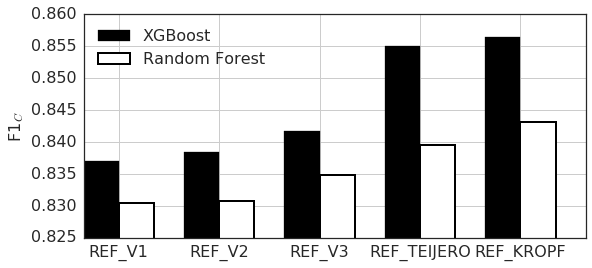

In [7]:
mpl.style.use('seaborn-white')


df_results=joblib.load('f1_by_reference.pkl')
#current_palette_4 = sns.color_palette("hls", 4)
#sns.set_palette(current_palette_4)

n_groups = len(REFERENCES)
index = np.arange(n_groups)

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 1
error_config = {'ecolor': '0.3'}


#sns.set_context("paper")
#plt.style.use(['seaborn-paper', 'seaborn-white'])
#matplotlib.rc("font", family="Times New Roman")


params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (9, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)




rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].F1, bar_width,
                alpha=opacity, color='black',
                yerr=None, error_kw=error_config,
                label='XGBoost')

rects2 = ax.bar(index + bar_width, df_results[df_results.Classifier=='RF'].F1, bar_width,
                alpha=opacity, color='white', edgecolor=['black']*len(index),
                yerr=None, error_kw=error_config,linewidth=2.0,
                label='Random Forest')

#x.set_xlabel('Reference',fontsize=FONT_SIZE)
ax.set_ylabel('F1$_{C}$',fontsize=FONT_SIZE)
#ax.set_title('F1 score by reference and classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(REFERENCES)
ax.legend(loc="upper left")
ax.set_ylim([0.825,0.86])
ax.grid()
#fig.set_facecolor('white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['savefig.force_edgecolor'] = True
#plt.rcParams['savefig.edgecolor'] = 'black'


#fig.tight_layout()
#plt.show()
plt.savefig('/notebooks/data/barchart_f1_score_by_reference.png',dpi=DPI)

In [ ]:
df_results[df_results.Classifier=='XGB']

In [ ]:
df_results[df_results.Classifier=='RF']

## Test by feature category

In [ ]:
feat_dha=pd.read_excel('/notebooks/data/fi_merged.xlsx')
categories=feat_dha.Category.unique()
categories=np.sort(categories)

categories

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

for category in categories:
    feat_sum_xgb= feat_dha[feat_dha.Category==category].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[feat_dha.Category==category].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[feat_dha.Category==category].ImportanceXGB)
    feat_count_rf= len(feat_dha[feat_dha.Category==category].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[feat_dha.Category==category].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_category.pkl', compress = 1)


### Test by excluding category

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

#categories=np.append(categories,'All')
#categories=np.sort(categories)

for category in categories:
    feat_sum_xgb= feat_dha[feat_dha.Category!=category].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[feat_dha.Category!=category].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[feat_dha.Category!=category].ImportanceXGB)
    feat_count_rf= len(feat_dha[feat_dha.Category!=category].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[feat_dha.Category!=category].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_excluding_category.pkl', compress = 1)

### Test by excluding category and meta

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

#categories=np.append(categories,'All')
#categories=np.sort(categories)

for category in categories:
    feat_sum_xgb= feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceXGB)
    feat_count_rf= len(feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_excluding_category_and_meta.pkl', compress = 1)

In [ ]:
df_results=joblib.load('f1_by_category.pkl')

#### XGBoost

In [ ]:
df_results[df_results.Classifier=='XGB']

#### RandomForest

In [ ]:
df_results[df_results.Classifier=='RF']

## Barchart: Feature importance by category

In [ ]:
n_groups = len(categories)
index = np.arange(n_groups)

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 1
error_config = {'ecolor': '0.3'}



rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].Importance, bar_width,
                alpha=opacity, color='black',
                yerr=None, error_kw=error_config,
                label='XGBoost')


#ax.set_xlabel('Category',fontsize=FONT_SIZE)
ax.set_ylabel('Importance',fontsize=FONT_SIZE)
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels(categories)
#ax.legend(loc="upper left")
ax.grid()
#plt.style.use('paper')
ax.set_ylim([0,0.35])


fig.tight_layout()
#plt.show()

params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (7, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)



plt.savefig('/notebooks/data/barchart_feature_importance_by_category.png',dpi=DPI)

## Barchart: F1 score by category and classifier

In [ ]:
n_groups = len(categories)
index = np.arange(n_groups)

fig, ax = plt.subplots()
bar_width = 0.35

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].F1, bar_width,
                alpha=opacity, color='black',
                yerr=None, error_kw=error_config,
                label='XGBoost')

#rects2 = ax.bar(index + bar_width, df_results[df_results.Classifier=='RF'].F1, bar_width,
#                alpha=opacity, color='b',
#                yerr=None, error_kw=error_config,
#                label='Random Forest')

#ax.set_xlabel('Category')
ax.set_ylabel('F1$_{CinC}$')
#ax.set_title('F1 on subset of features per category')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(categories)
#ax.legend(loc="upper left")
ax.set_ylim([0.3,0.85])
ax.grid()

fig.tight_layout()
#plt.show()
plt.savefig('/notebooks/data/barchart_f1_by_category.png',dpi=DPI)

## Barchart: F1 score by excluded category and classifier

In [ ]:
df_results=joblib.load('f1_by_excluding_category.pkl')
df_results

In [ ]:
fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

n_groups = len(categories)


index = np.arange(n_groups)

rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].F1, bar_width,
                alpha=opacity,color='b',
                yerr=None, error_kw=error_config,
                label='XGBoost')

rects2 = ax.bar(index + bar_width, df_results[df_results.Classifier=='RF'].F1, bar_width,
                alpha=opacity,
                yerr=None, error_kw=error_config,color='r',
                label='Random Forest')

#ax.set_xlabel('Category')
ax.set_ylabel('F1')
#ax.set_title('F1 on subset of features per category')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories)
ax.legend(loc="upper left")
#ax.set_ylim([0.815,0.85])
ax.set_ylim([0.81,0.85])
ax.grid()



fig.tight_layout()
plt.plot();

#plt.show()
plt.savefig('/notebooks/data/barchart_f1_by_excluded_category_and_classifier.png',dpi=100)

In [ ]:
df_results

## Test features by importance

In [ ]:
feat_dha=pd.read_excel('/notebooks/data/fi_merged.xlsx')

fi_sorted_xgb=feat_dha.sort_values(by='ImportanceXGB', ascending=False)
fi_sorted_rf=feat_dha.sort_values(by='ImportanceRF', ascending=False)

idx_range=np.arange(1,387,1)
#idx_range=[50,100,200,300,386]

print(idx_range)

df_results=pd.DataFrame(columns=['Count','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise'])

for idx in idx_range:
    #XGBoost
    display(idx)
    feature_names=fi_sorted_xgb.tail(n=386-idx).Name
    df_reduced=df.drop(feature_names,axis=1)
    X_reduced=df_reduced.as_matrix()
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_reduced=imp.fit_transform(X_reduced)
    print(X_reduced.shape)
    clf = XGBClassifier(**params).fit(X_reduced, y,verbose=50)
    a1, a2=test_classifier(clf,X_reduced,y)
    df_results=df_results.append({'Count': idx,'Classifier':'XGB','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)
    
    #Random Forest
    feature_names=fi_sorted_rf.tail(n=386-idx).Name
    df_reduced=df.drop(feature_names,axis=1)
    X_reduced=df_reduced.as_matrix()
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_reduced=imp.fit_transform(X_reduced)
    print(X_reduced.shape)
    clf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_reduced, y)
    a1, a2=test_classifier(clf,X_reduced,y)
    df_results=df_results.append({'Count': idx,'Classifier':'RF','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)

joblib.dump(df_results, 'top_n_feat.pkl', compress = 1)
#joblib.dump(f1_class_scores, 'f1_class_scores_rf.pkl', compress = 1)

## Plot: Number of features - F1 score

In [ ]:
df_results=joblib.load('top_n_feat.pkl')


plt.figure(0)
ax = plt.axes()
plt.grid()



ax.set_xticks([100, 200,300])

params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (5, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}

plt.rcParams.update(params)
plt.plot(df_results[df_results.Classifier=='XGB'].F1.reset_index(drop=True), color='cornflowerblue',label='XGBoost')
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1$_{C}$ score')
plt.plot(df_results[df_results.Classifier=='RF'].F1.reset_index(drop=True), color='red',label='Random Forest')



plt.legend(loc='lower right')
plt.ylabel('F1$_{C}$ score')
plt.xlabel('Number of features')
plt.tight_layout()

plt.savefig('linechart_n_feat_vs_f1.png',dpi=DPI)

#plt.show()

plt.figure(1)
ax = plt.axes()
ax.set_xticks([100, 200,300])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1$_{CinC}$ score')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Normal'].reset_index(drop=True), label='Normal')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 AF'].reset_index(drop=True), label='AF')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Other'].reset_index(drop=True), label='Other')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Noise'].reset_index(drop=True), label='Noise')
plt.legend(loc='lower right')
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.rcParams.update(params)
plt.tight_layout()
#plt.show()

plt.savefig('linechart_n_feat_vs_f1_per_class.png',dpi=DPI)

#plt.show()

# Test for statistical difference on N runs with random seed

Tests the classifier N times using a pseudo-random seed, based on current microsecond

In [ ]:
N=100 #number of runs

df_results=pd.DataFrame(columns=['Iteration','Seed','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Training Time'])

for i in range(1,N+1):
    print('\nIteration',i,'Seed',seed)
    seed = datetime.datetime.now().microsecond
    cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)
    
    tic('Train XGB')
    bst = XGBClassifier(**params).fit(X, y,verbose=50)
    train_xgb_time=toc()
    a1,a2=test_classifier(bst,X,y)
    df_results=df_results.append({'Iteration': i,'Seed':seed,'Classifier':'XGB','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Training Time':train_xgb_time},ignore_index=True)

    tic('Train RF')
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
    train_rf_time=toc()
    a1,a2=test_classifier(rf,X,y)
    df_results=df_results.append({'Iteration': i,'Seed':seed,'Classifier':'RF','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Training Time':train_rf_time},ignore_index=True)

joblib.dump(df_results, 'f1_100_runs.pkl', compress = 1)

### Boxplot: XGB vs. RF

XGB: 0.839 +/- 0.003, RF 0.833 +/- 0.002
p-Value: 0.00000000000000000000000000000000000000000000000006
p-Value: 0.00000000000000000389655984509590921748877339445397


/opt/conda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


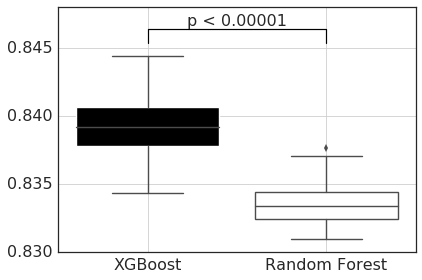

In [12]:
df_results=joblib.load('f1_100_runs.pkl')
mpl.style.use('seaborn-white')

iqr_xgb=df_results[df_results.Classifier=='XGB'].F1.quantile(0.75)-df_results[df_results.Classifier=='XGB'].F1.quantile(0.25)
iqr_rf=df_results[df_results.Classifier=='RF'].F1.quantile(0.75)-df_results[df_results.Classifier=='RF'].F1.quantile(0.25)


print("XGB: %.3f +/- %.3f, RF %.3f +/- %.3f"%(df_results[df_results.Classifier=='XGB'].F1.median(),iqr_xgb,df_results[df_results.Classifier=='RF'].F1.median(),iqr_rf))
statistic,p_value=stats.ttest_rel(df_results[df_results.Classifier=='XGB'].F1,df_results[df_results.Classifier=='RF'].F1)
print('p-Value: %.50f' % (float(p_value)))
statistic,p_value=stats.wilcoxon(df_results[df_results.Classifier=='XGB'].F1,df_results[df_results.Classifier=='RF'].F1)
print('p-Value: %.50f' % (float(p_value)))
                                                        
df_f1_xgb=df_results[df_results.Classifier=='XGB'].F1.reset_index(drop=True)
df_f1_rf=df_results[df_results.Classifier=='RF'].F1.reset_index(drop=True)
df_f1=pd.concat([df_f1_xgb,df_f1_rf],axis=1)

df_f1.columns = ['XGBoost', 'Random Forest']
#display(df_f1)

#sns.set_style("whitegrid")
sns.set_context("paper")
plt.style.use(['seaborn-paper', 'seaborn-white'])
#matplotlib.rc("font", family="Times New Roman")

rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

ax = sns.boxplot(data=df_f1)
  
box = ax.artists[1]
box.set_facecolor('white')

box = ax.artists[0]
box.set_facecolor('black')
box.set_edgecolor('white')



x1, x2 = 0, 1 
y, h, col = df_f1_xgb.max()+0.001, 0.0010, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c=col)
ax.text((x1+x2)*.5, y+h, "p < 0.00001", ha='center', va='bottom')
ax.grid()
fig = ax.get_figure()



fig.savefig('boxplot_xgb_vs_rf.png', format='png', dpi=DPI)

## Feature importance table

In [ ]:
def fi_table(clf,df):
    fi=pd.DataFrame(clf.feature_importances_)
    #display(fi)
    fi.columns = ['Importance']
    cols=pd.DataFrame(list(df.columns))
    cols.columns = ['Feature']
    result = pd.concat( [fi, cols], axis=1)
    fi_sorted=result.sort_values(by='Importance', ascending=False)
    return fi_sorted

fi_sorted=fi_table(rf,df)
fi_sorted.to_excel('/notebooks/data/fi_rf.xlsx')

## XGBoost

### Train

In [ ]:
tic('Train XGB')
print(params)
bst = XGBClassifier(**params).fit(X, y,verbose=50)
joblib.dump(bst, 'xgboost_joblib.pkl', compress = 1)
a=toc()
print(a)

### Test

In [ ]:
tic('Test XGB')
test_classifier(bst,X,y)
toc()

In [ ]:
tic('Test XGB prediction runtime')
y=bst.predict(X)
toc()

## Random Forest

### Train

In [ ]:
tic('Train RF')
rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
joblib.dump(rf,'rf_joblib.pkl', compress = 1)
toc()

### Test

In [ ]:
tic('Test RF')
test_classifier(rf, X,y)
toc()

In [ ]:
tic('Test RF prediction runtime')
y=rf.predict(X)
toc()

# Cross validated predictions of model

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(bst, X, y,cv=cv)
answers = pd.concat([rec,pd.DataFrame(y_pred)], axis=1)
answers.to_csv('y_5xCV_xgb.txt',index=None,header=None)

y_pred = cross_val_predict(rf, X, y,cv=cv)
answers = pd.concat([rec,pd.DataFrame(y_pred)], axis=1)
answers.to_csv('y_5xCV_rf.txt',index=None,header=None)

# Neural Network: Train and test

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(alpha=0.01, random_state=seed)

nn=nn.fit(X, y)    
print(nn)
test_classifier(nn,X,y)

In [ ]:
plt.style.available

#### Rename categories

In [ ]:
df_results=joblib.load('f1_by_category.pkl')
df_results=df_results.replace('Average beat','Average')
df_results=df_results.replace('QRS detection','QRS')
joblib.dump(df_results, 'f1_by_category.pkl', compress = 1)
df_results